### Train DNN

In [1]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, TensorDataset, DataLoader
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import torch.nn.functional as F
import sys
module_path = Path().resolve().parents[1] / "src" / "models"

# Append the directory to sys.path
sys.path.append(str(module_path))


from trainDNN import *
from explainDNN import *
from predictDNN import *

module_path = Path().resolve().parents[1] / "src" / "postprocessing"

# Append the directory to sys.path
sys.path.append(str(module_path))


from getModelPerformance import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Load features

In [2]:
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_DO_men_2_3_84_1"
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labels.npy"))
lats = np.load(Path(feature_path / "numpy_lat.npy"))
lons = np.load(Path(feature_path / "numpy_lon.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)


In [3]:
features.shape[1]

139

In [4]:
features.shape

(13807, 139)

#### Define the neural network architecture

In [5]:
loss_fn = torch.nn.MSELoss()


In [6]:
class DNN(torch.nn.Module):
    def __init__(self, layer_width):
        super(DNN, self).__init__()

        self.do_prob = 0.2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(features.shape[1], layer_width[0]),
            torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], layer_width[1]),
            torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[2]),
            torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[3]),
            torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[4]),
            torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[5]),
            torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[6]),
            torch.nn.BatchNorm1d(layer_width[6]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
        )

        self.decoder = torch.nn.Sequential(

            torch.nn.Linear(layer_width[6], layer_width[5]),
            #torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[4]),
            #torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[3]),
            #torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[2]),
            #torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[1]),
            #torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[0]),
            #torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], features.shape[1])
        )

        self.supervised = torch.nn.Sequential(
            torch.nn.Linear(layer_width[6], layer_width[7]),
            torch.nn.BatchNorm1d(layer_width[7]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[7], layer_width[8]),
            torch.nn.BatchNorm1d(layer_width[8]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[8], layer_width[9]),
            torch.nn.BatchNorm1d(layer_width[9]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[9], 1)

        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        targets = self.supervised(encoded)
        #return decoded, targets
        return targets
        
def initialize_weights(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)


In [7]:

input_dim = features.shape[1]  # Replace with the actual input dimension
layer_widths = [128, 128, 128, 128, 128, 128, 128, 128, 128, 128]  # Define your desired layer widthsmodel = DNN(layer_widths)#DNN(input_dim, layer_widths)model = DNN(layer_widths)#DNN(input_dim, layer_widths)



In [8]:
# Model Initialization
model = DNN(layer_widths)
model = model.double()
model.apply(initialize_weights)


if torch.cuda.is_available():
    model = model.cuda()
    loss_fn = loss_fn.cuda()



In [9]:
features.shape

(13807, 139)

In [10]:
features, labels, lats, lons = preprocess_features_labels(features, labels, lats, lons, X_mean, X_std) 
np.save("preprocessed/features_DO_2_3_84_1", features)
np.save("preprocessed/labels_DO_2_3_84_1", labels)
np.save("preprocessed/lats_DO_2_3_84_1", lats)
np.save("preprocessed/lons_DO_2_3_84_1", lons)

Duplicate row with index [  172   476   884   941  1189  1316  1362  1747  2277  3117  3360  3563
  3864  4089  4521  4892  5730  5864  6302  6857  7077  7160  7398  8792
 10026 11018 11139 11144 12043] was in group 83 and was replaced with NaN values
Duplicate row with index [3192 5025 7265] was in group 93 and was replaced with NaN values
Duplicate row with index [  705   961  2224  6943  9024 12516 12821] was in group 107 and was replaced with NaN values
Duplicate row with index [  906  1139  1763  2593  2998  4414  5399  6091  6143  6556  7541  9424
 10479 11017 11509 12527 12564 12692 13411] was in group 120 and was replaced with NaN values
Duplicate row with index [  602  1361  2127  2457  2470  2948  3057  3068  4559  4982  6013  6029
  6806  7584  8375  9137 10128 10500 10696 11150 11189 11212 11224 11974
 12437 12695 12800 12973 13274] was in group 123 and was replaced with NaN values
Duplicate row with index [ 3877 13781] was in group 129 and was replaced with NaN values
Dupl

In [10]:
features = np.load("preprocessed/features_DO_2_3_84_1.npy")
labels = np.load("preprocessed/labels_DO_2_3_84_1.npy")

In [11]:
features = torch.tensor(features)
labels = torch.tensor(labels)

In [12]:

trainloader, testloader = create_train_test_loader(features, labels, batch_size = 200, test_size_ratio=1/7, shuffle=True)

Train data size
4868
Test data size
811


In [13]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affi

In [14]:
# GPU intensive operation!!
num_epochs = 1000
training_accuracy, training_losses, training_mae, learning_rate, evaluation_losses, evaluation_mae, true_labels, pred_labels =  train_model(model, loss_fn, trainloader, testloader, num_epochs = num_epochs)

epoch: 0 | Training Loss: 1.846 | MAE: 0.820 | LR: 0.0100000 |
epoch: 0 | Testing Loss: 9.144 | MAE: 1.443  |

epoch: 1 | Training Loss: 1.109 | MAE: 0.597 | LR: 0.0100000 |
epoch: 1 | Testing Loss: 0.889 | MAE: 0.518  |

epoch: 2 | Training Loss: 0.982 | MAE: 0.551 | LR: 0.0100000 |
epoch: 2 | Testing Loss: 0.959 | MAE: 0.539  |

epoch: 3 | Training Loss: 1.026 | MAE: 0.542 | LR: 0.0100000 |
epoch: 3 | Testing Loss: 0.658 | MAE: 0.474  |

epoch: 4 | Training Loss: 0.866 | MAE: 0.517 | LR: 0.0100000 |
epoch: 4 | Testing Loss: 0.506 | MAE: 0.383  |

epoch: 5 | Training Loss: 0.877 | MAE: 0.510 | LR: 0.0100000 |
epoch: 5 | Testing Loss: 0.533 | MAE: 0.449  |

epoch: 6 | Training Loss: 0.901 | MAE: 0.498 | LR: 0.0100000 |
epoch: 6 | Testing Loss: 0.459 | MAE: 0.390  |

epoch: 7 | Training Loss: 0.839 | MAE: 0.482 | LR: 0.0080000 |
epoch: 7 | Testing Loss: 0.407 | MAE: 0.386  |

epoch: 8 | Training Loss: 0.763 | MAE: 0.460 | LR: 0.0080000 |
epoch: 8 | Testing Loss: 0.436 | MAE: 0.388  |

e

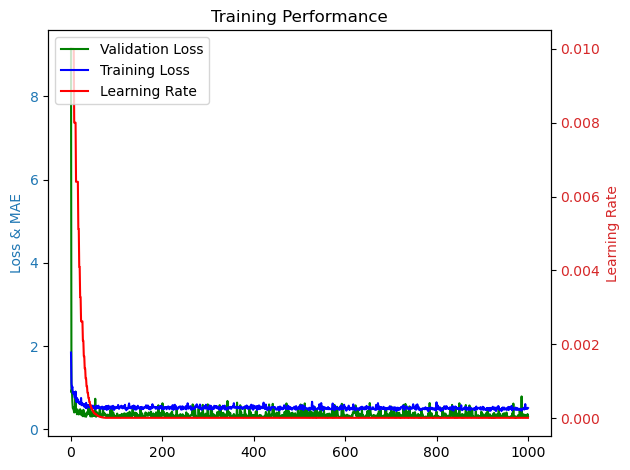

In [15]:
#num_epochs = 1000
plot_model_performance(num_epochs, evaluation_losses, training_losses, learning_rate)

In [16]:
output_path = Path().resolve().parents[2] / "nn4sedratetoc" / "data" / "output" / "scatterplots_TOC" / "scatter_plot_TOC_noconstraint_supervised_DO_men_2_3_84_1.png"
output_path = str(output_path)
test_labels, test_targets = evaluate_model(model, testloader, output_path)

(811,)
(811,)
correlation coefficient:
0.8505608210206831
mae:
0.3506065699975731
mse:
0.3339962815214656
rmse:
0.5779241139816417


In [17]:
all_labels, all_targets =  evaluate_all_predictions(model, features, labels, output_path)

correlation coefficient:
0.8784173193387894
mae:
0.31618992712332744
mse:
0.358500664451933
rmse:
0.598749250063775


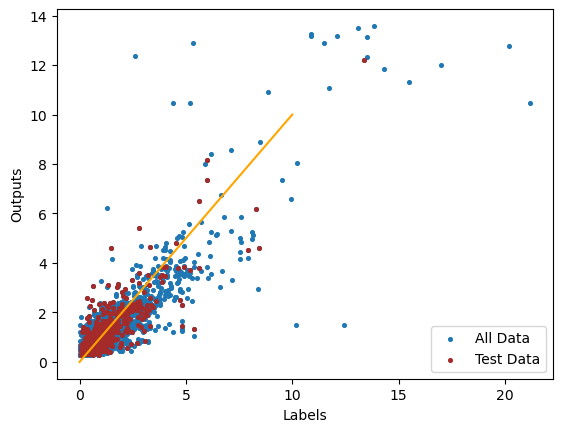

In [18]:
# Scatter plot with different colors for test labels and test targets
plt.scatter(all_labels, all_targets, label='All Data', s= 7)
plt.scatter(test_labels, test_targets, label='Test Data', color='brown', s=7)  # Add this line

line = np.linspace(0, 10, 100)

# Plot the reference line
plt.plot(line, line, 'orange')

# Set labels and title
plt.xlabel("Labels")
plt.ylabel("Outputs")

# Add legend
plt.legend()

In [19]:
#"""
np.save("all_labels_NN_DO_2_3_84_1", all_labels)
np.save("all_predictions_NN_DO_2_3_84_1", all_targets)
np.save("test_labels_NN_DO_2_3_84_1", test_labels)
np.save("test_predictions_NN_DO_2_3_84_1", test_targets)
#"""

### Explain DNN using SHAP values (Find feature importance)

In [24]:
import shap
import pandas as pd

# Convert the input features to a PyTorch tensor with the correct data type
features = torch.tensor(features, dtype=torch.float64)

if torch.cuda.is_available():
    features = features.cuda()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


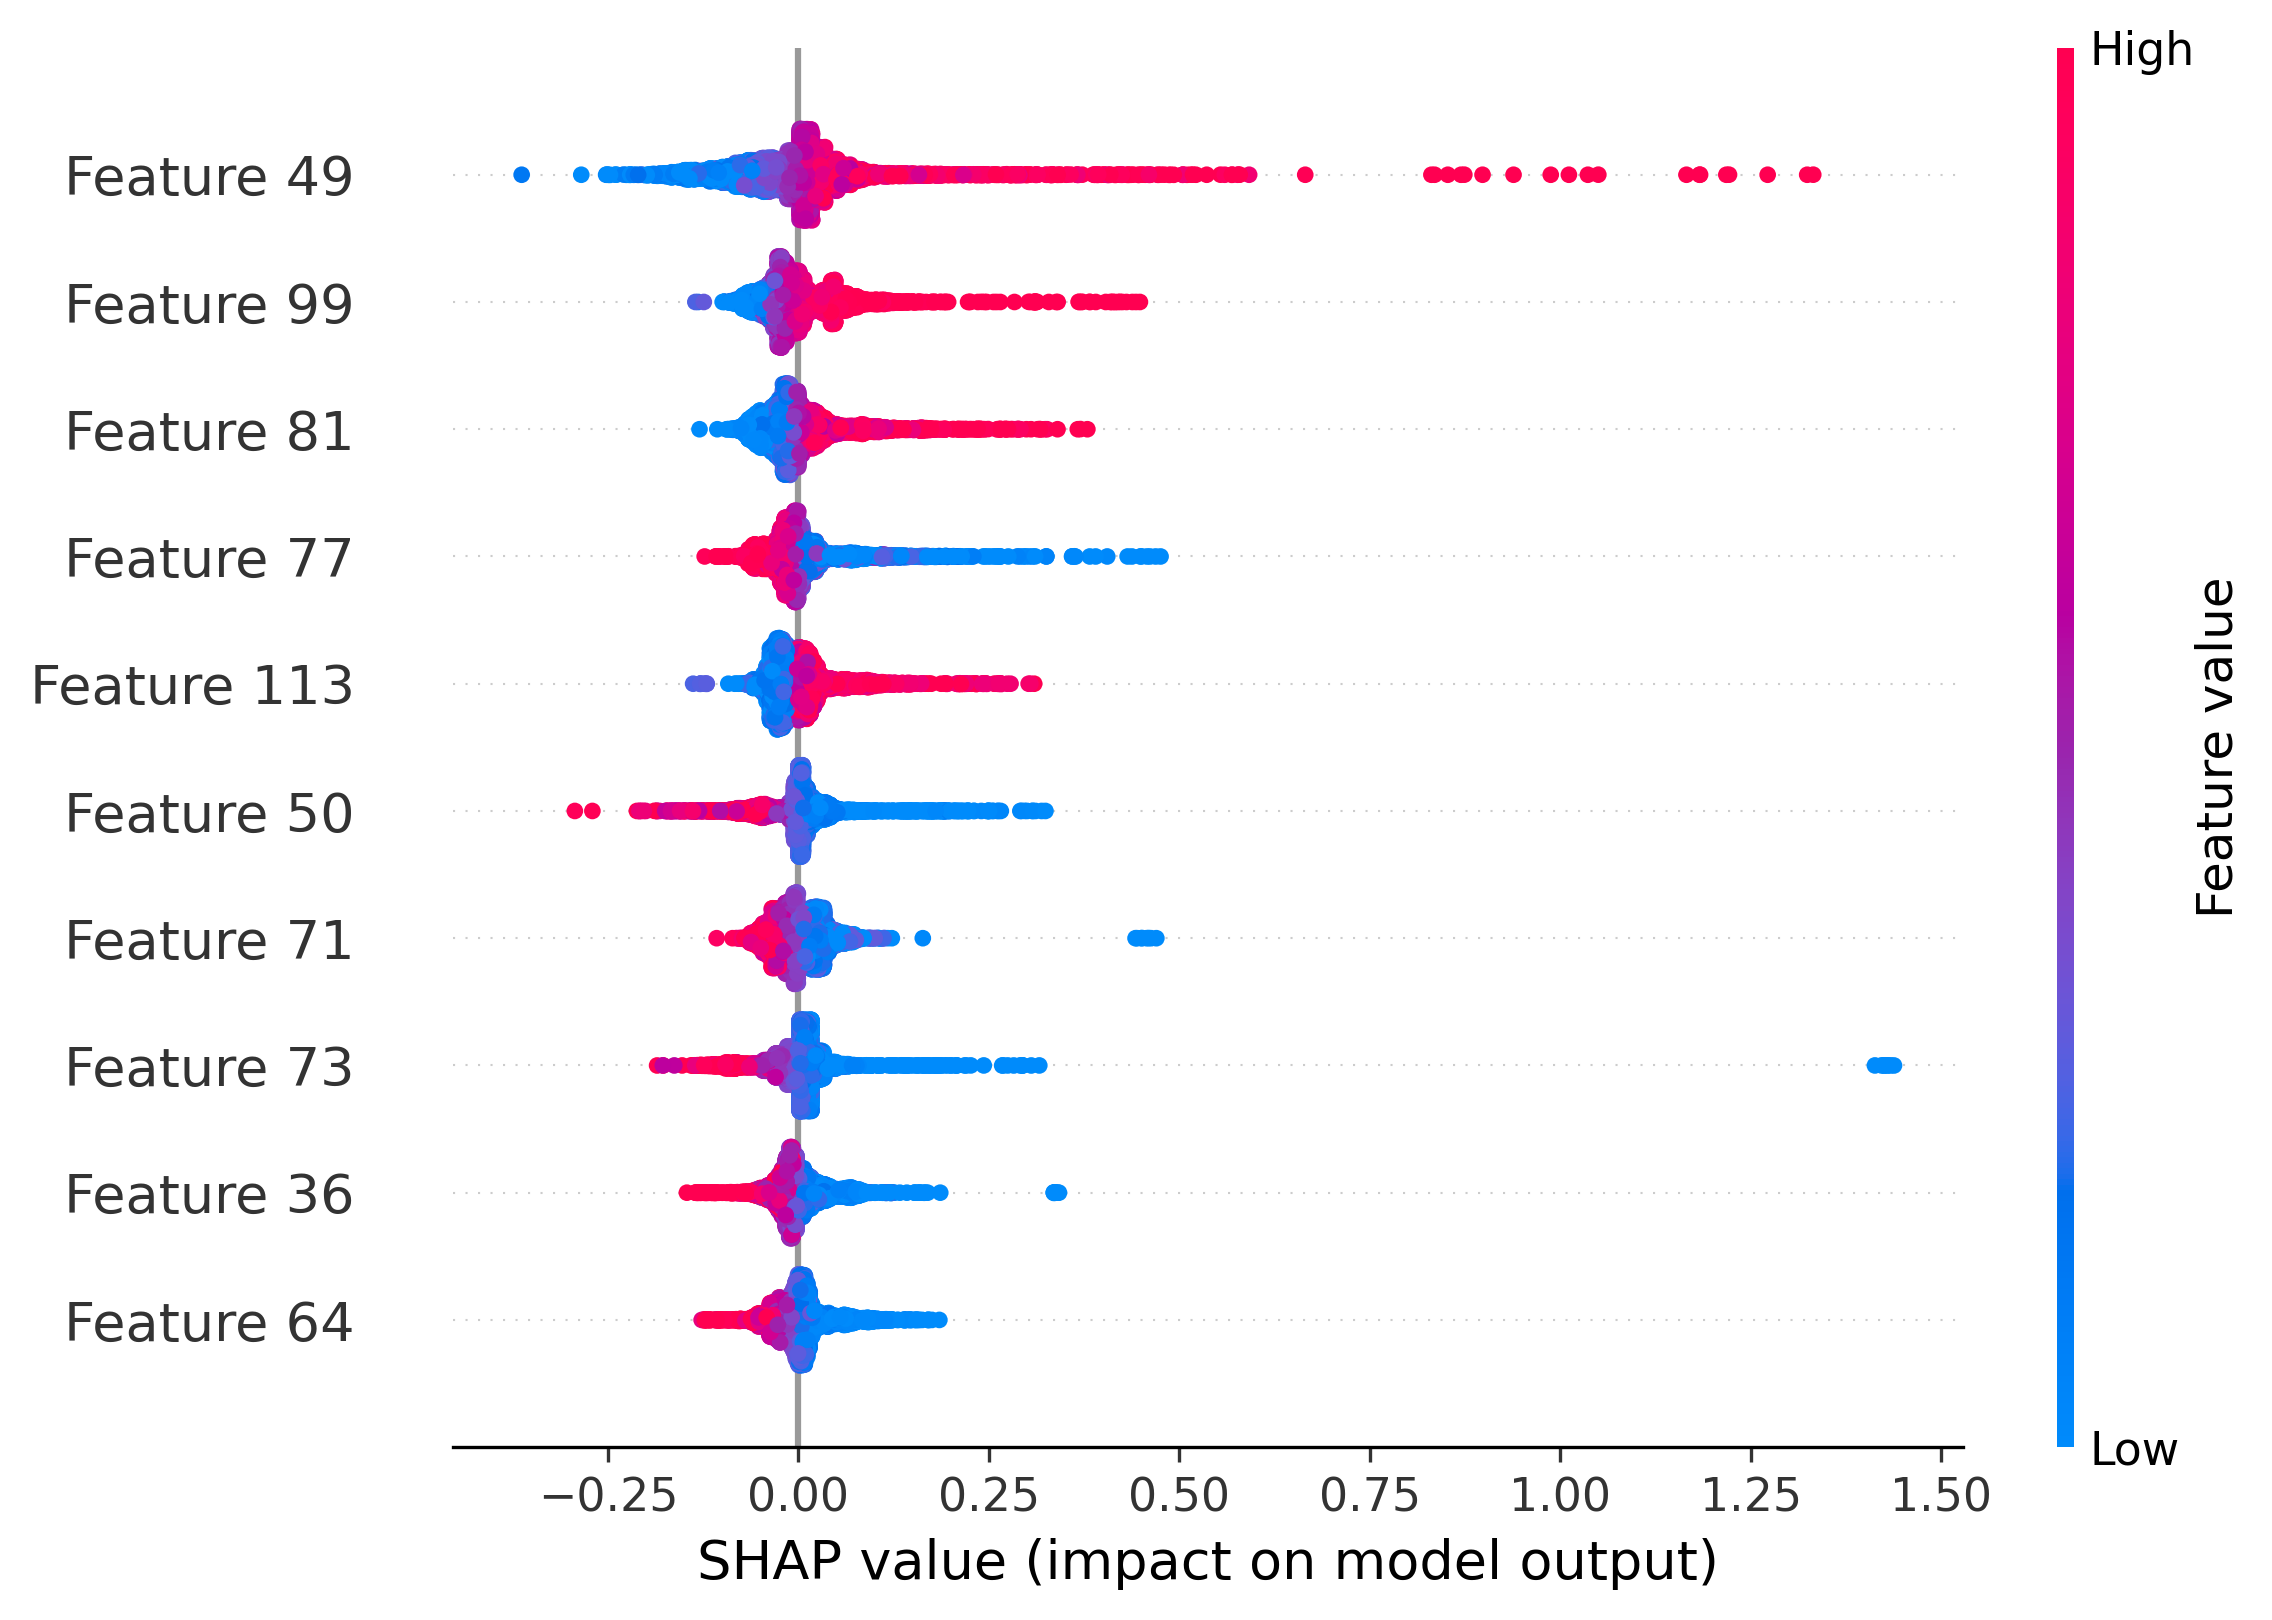

In [25]:
# GPU intensive operation!!!
explain_shap(model, features, feature_names=None, explainer_path='preprocessed/explainer_DO.pkl', shap_values_path='preprocessed/shap_values_DO.pkl', force_plot_index=0, summary_max_display=10)

# Load the explainer and SHAP values
with open('preprocessed/explainer_DO.pkl', 'rb') as explainer_file:
    explainer = pickle.load(explainer_file)

with open('preprocessed/shap_values_DO.pkl', 'rb') as shap_values_file:
    shap_values = pickle.load(shap_values_file)

In [27]:
torch.save(model.state_dict(), path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_DO.pth")

### Predict using the trained DNN

In [11]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
import gc






from os import walk  
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_DO_men_2_3_84_1"
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)

#dataset_path = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "WorldFeaturesAll")#ChlorWorldFeatures
dataset_path = Path().resolve().parents[1] / "data" / "interim" / "worldfeatures" / "WorldFeaturesAllnoNaN_SedTOC"
files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()


features = np.load(Path(dataset_path / files[0]))
prediction_sum_save = Path().resolve().parents[1] / "data" / "interim" / "predictions" / "predictions_DO_2_3_84_1"

In [21]:

model.eval()
enable_dropout(model) #for mc dropout


chunk_shape = [6,4320] #360 chunks

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
print(device)
model.double()



cuda:0


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [22]:
features = np.load(Path(dataset_path / files[0]))

chunk_shape = [6,4320] #360 chunks


first_run = True
ii = 0

for count, file in enumerate(files):
    #if count > 2:
    #    break
    features = np.load(Path(dataset_path / file))
    features = np.divide((features - X_mean), X_std)

    features = torch.tensor(features)
    features = features.to(device)

    # Perform multiple forward passes with dropout
    num_samples = 100  # number of monte carlo forward passes: gives us the number of predictions or the size of the prediction ensemble
    predictions_sum = np.zeros((num_samples, chunk_shape[0], chunk_shape[1]))

    with torch.no_grad():
        for i in range(num_samples):
            predictions = model(features)
         
            # Store predictions for later averaging
            predictions_sum[i] = predictions.cpu().detach().numpy().reshape(chunk_shape)

    # Average predictions over all samples
    predictions_avg = np.mean(predictions_sum, axis=0)
    predictions_var = np.var(predictions_sum, axis=0)
    save_path = os.path.join(prediction_sum_save , f'predictions_sum_{ii}.npy')
    np.save(save_path, predictions_sum)
    #fit_params, failed_fits, failed_fit_details = fit_gaussian_to_predictions(predictions_sum)
    #print(failed_fits)

    if first_run:
        prediction_map2 = predictions_avg
        prediction_map2_var = predictions_var
        first_run = False
    else:
        prediction_map2 = np.append(prediction_map2, predictions_avg, axis=0)
        prediction_map2_var = np.append(prediction_map2_var, predictions_var, axis=0)

    ii += 1
    print("Prediction " + str(ii) + " done!")

    del features
    gc.collect()
    


Prediction 1 done!
Prediction 2 done!
Prediction 3 done!
Prediction 4 done!
Prediction 5 done!
Prediction 6 done!
Prediction 7 done!
Prediction 8 done!
Prediction 9 done!
Prediction 10 done!
Prediction 11 done!
Prediction 12 done!
Prediction 13 done!
Prediction 14 done!
Prediction 15 done!
Prediction 16 done!
Prediction 17 done!
Prediction 18 done!
Prediction 19 done!
Prediction 20 done!
Prediction 21 done!
Prediction 22 done!
Prediction 23 done!
Prediction 24 done!
Prediction 25 done!
Prediction 26 done!
Prediction 27 done!
Prediction 28 done!
Prediction 29 done!
Prediction 30 done!
Prediction 31 done!
Prediction 32 done!
Prediction 33 done!
Prediction 34 done!
Prediction 35 done!
Prediction 36 done!
Prediction 37 done!
Prediction 38 done!
Prediction 39 done!
Prediction 40 done!
Prediction 41 done!
Prediction 42 done!
Prediction 43 done!
Prediction 44 done!
Prediction 45 done!
Prediction 46 done!
Prediction 47 done!
Prediction 48 done!
Prediction 49 done!
Prediction 50 done!
Predictio

In [ ]:
#"""
import os
import numpy as np

# Get a list of files in the directory and sort them
files_in_dir = sorted([f for f in os.listdir(prediction_sum_save) if f.endswith('.npy')], key=lambda x: int(x.split('_')[-1][:-4]))


failed_fits_all = []
i = 0
first_run = True

# Load and concatenate each predictions_sum array along the second axis
for file in files_in_dir:
    file_path = os.path.join(prediction_sum_save, file)
    predictions_sum = np.load(file_path)
    
    if first_run:
        prediction_map_dist = predictions_sum
        first_run = False
    else:
        # Concatenate along the second axis (axis=1)
        prediction_map_dist = np.concatenate((prediction_map_dist, predictions_sum), axis=1)

    i += 1
    print(i)
np.save(Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_dist_DO_2_3_84_1.npy", prediction_map_dist)
#"""

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [24]:
land_file = Path().resolve().parents[1] / "data" / "raw" / "island_map.npy"
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1

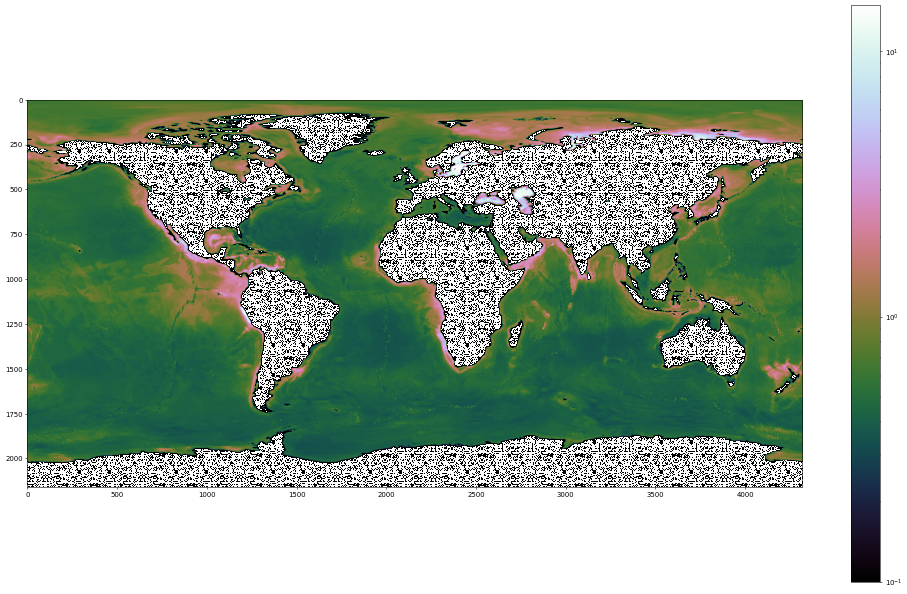

In [25]:
import matplotlib.colors as mcolors
prediction_map2 = np.rot90(np.rot90(np.fliplr(prediction_map2)))
plt.figure(figsize=[25, 15], dpi=50)
prediction_map2[land_map] = 0
plt.imshow(prediction_map2, norm=mcolors.LogNorm(vmin=1e-1, vmax=15),cmap="cubehelix")
cbar = plt.colorbar()

In [26]:

np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_TOC_men_DO_2_3_84_1.npy", prediction_map2)
#np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "uncertainty_map_TOC_noconstraint_supervised_men_DO.npy", prediction_map2_var)